In [1]:
!pip install pytorch-lightning sentence-transformers torchmetrics rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 k

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/MyDrive/NLP Project/src')
os.getcwd()

'/content/drive/MyDrive/NLP Project/src'

# Roberta Baseline

## Task 3

### Prepare the Data

In [4]:
import pandas as pd
from datautils import SynDataModule, SynBatcher


TASK = 3
DPATH = r'../data/new_punc_data_eval.csv'
MPATH = "roberta-base"

df = pd.read_csv(DPATH)

label2id = {'human': 0, 'fair': 1, 'grover': 2, 'gpt2': 3, 'gpt3': 4, 'instructgpt': 5, 'gpt': 6, 'ctrl': 7, 'pplm': 8, 'xlnet': 9, 'xlm': 10}
id2label = {v:k for k,v in label2id.items()}

In [5]:
batcher = SynBatcher(tnkzr_path=MPATH)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher)

### Prepare the model

In [6]:
from modelling import SequenceClassification
from pytorch_lightning.callbacks import(
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary
)

SAVE_PATH = "'../models/task3/roberta-base"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")

model = SequenceClassification.load_from_checkpoint("../models/task3/roberta-base/task-3-epoch=0-val_loss=0.15.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

### Generate model predictions

In [7]:
from pytorch_lightning import Trainer, seed_everything


seed_everything(42, workers=True)

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [8]:
trainer.test(model,eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_granular_f1_score_Ctrl     │                0.0                 │
│     test_granular_f1_score_GPT     │                0.0                 │
│   test_granular_f1_score_Grover    │                0.0                 │
│    test_granular_f1_score_fair     │                0.0                 │
│    test_granular_f1_score_gpt2     │                0.0                 │
│    test_granular_f1_score_gpt3     │         0.5731402039527893         │
│    test_granular_f1_score_human    │                0.0                 │
│ test_granular_f1_score_instructgpt │                0.0                 │
│    test_granular_f1_score_pplm     │                0.0                 │
│     test_granular_f1_score_xlm     │        0.010230178944766521        │
│    test_granular_f1_score_xlnet    │                0.0                 │
│             test_loss              │         7.479757785797119          │
│        test_macro_f1_score         │        0.053033653646707535        │
│       test_overall_f1_score        │        0.09207160770893097         │
└────────────────────────────────────┴────────────────────────────────────┘

[{'test_loss': 7.479757785797119,
  'test_overall_f1_score': 0.09207160770893097,
  'test_macro_f1_score': 0.053033653646707535,
  'test_granular_f1_score_Ctrl': 0.0,
  'test_granular_f1_score_GPT': 0.0,
  'test_granular_f1_score_xlnet': 0.0,
  'test_granular_f1_score_fair': 0.0,
  'test_granular_f1_score_human': 0.0,
  'test_granular_f1_score_instructgpt': 0.0,
  'test_granular_f1_score_gpt3': 0.5731402039527893,
  'test_granular_f1_score_pplm': 0.0,
  'test_granular_f1_score_xlm': 0.010230178944766521,
  'test_granular_f1_score_gpt2': 0.0,
  'test_granular_f1_score_Grover': 0.0}]

In [9]:
batcher = SynBatcher(tnkzr_path=MPATH,has_targets=False)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher)

In [10]:
preds = trainer.predict(model,eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [11]:
import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))

In [12]:
df_pred = pd.DataFrame(pred_data)

In [13]:
filtered_df = df[df['src']=='aa_paper']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  temp.append([c,label2id[rows['alg']]])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)

         0  1
0        0  0
1        1  1
2        2  2
3        3  3
4        4  2
...    ... ..
1168  1168  8
1169  1169  1
1170  1170  6
1171  1171  8
1172  1172  2

[1173 rows x 2 columns]


[[  0   0   0 107   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 107   0   0]
 [  0   0   0   0   0   0   0 106   0   0   0]
 [  0   0   0   0 107   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1 105]
 [  0   0   1   0   0   0   0   0   0 106   0]
 [  0   0   0   0   0   1 106   0   0   0   0]
 [  0 107   0   0   0   0   0   0   0   0   0]
 [  0   0 104   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0 106   0   0   0   0]
 [107   0   0   0   0   0   0   0   0   0   0]]


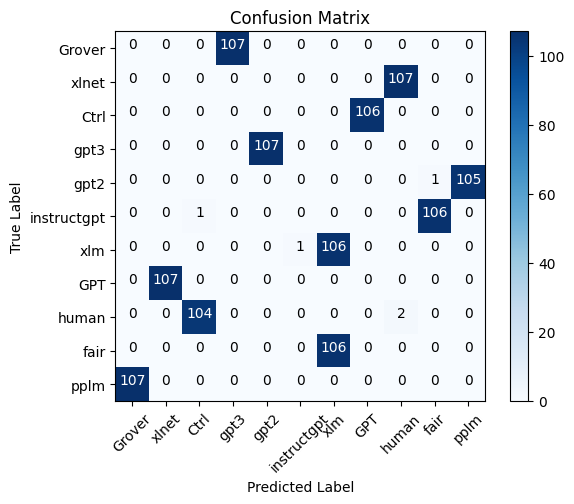

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = ['Grover', 'xlnet', 'Ctrl', 'gpt3', 'gpt2', 'instructgpt', 'xlm', 'GPT', 'human', 'fair', 'pplm']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Get Score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,y_true,target_names=list(label2id.keys())))

# Reddit Data

In [ ]:
DPATH = r'../data/new_punc_data_reddit.csv'
batcher = SynBatcher(tnkzr_path=MPATH,has_targets=False)
eval_dm = SynDataModule(data_path=DPATH, task='aa', label2id=label2id, batcher=batcher,srcs_to_keep=['reddit'])
preds = trainer.predict(model,eval_dm)
import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))
df_pred = pd.DataFrame(pred_data)
filtered_df = df[df['src']=='reddit']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  temp.append([c,label2id[rows['alg']]])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = list(label2id.keys())
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Get Score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,y_true,target_names=list(label2id.keys())))

## Task 2

### Prepare the Data

In [28]:
TASK = 2

label2id = {
    'human': 0,
    'machine': 1 
}
DPATH = r'../data/new_punc_data_eval.csv'

In [30]:
batcher = SynBatcher(tnkzr_path=MPATH)
eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher,srcs_to_keep=['aa_paper'])
# train_dm.setup('fit')

### Prepare the model

In [17]:
from modelling import SequenceClassification
from pytorch_lightning.callbacks import(
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary
)

SAVE_PATH = "../models/task2/roberta-base"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")
model = SequenceClassification.load_from_checkpoint("../models/task2/roberta-base/task-2-epoch=4-val_loss=0.31.ckpt")

checkpoint_callback = ModelCheckpoint(
    SAVE_PATH,
    filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
    monitor='val_loss',
    save_weights_only=True,
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, patience=8,
    verbose=False,
    mode="min"
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

### Train the model

In [18]:
#This looks the same as the first trainer
from pytorch_lightning import Trainer, seed_everything

seed_everything(42, workers=True)

trainer = Trainer(
    max_epochs=-1,
    deterministic=True,
    accumulate_grad_batches=4,
    callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
    accelerator='gpu',
    log_every_n_steps=16
)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

macro_f1_score_list = []
overall_f1_score_list = []
for i in range(10):
    DPATH = r'../data/punc_data_eval_'+str(i+1)+'.csv'
    batcher = SynBatcher(tnkzr_path=MPATH)
    eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher)
    print()
    print("F1 for",i+1,DPATH)
    print()
    x = trainer.test(model, eval_dm)
    print()
    macro_f1_score_list.append(x[0]['test_macro_f1_score'])
    overall_f1_score_list.append(x[0]['test_overall_f1_score'])


F1 for 1 ../data/punc_data_eval_1.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9504713416099548       │
│           test_loss            │      0.31073710322380066       │
│      test_macro_f1_score       │       0.4752356708049774       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 2 ../data/punc_data_eval_2.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9497847557067871       │
│           test_loss            │       0.3107367753982544       │
│      test_macro_f1_score       │      0.47489237785339355       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 3 ../data/punc_data_eval_3.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9504713416099548       │
│           test_loss            │      0.31073692440986633       │
│      test_macro_f1_score       │       0.4752356708049774       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 4 ../data/punc_data_eval_4.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9501495957374573       │
│           test_loss            │       0.3107369840145111       │
│      test_macro_f1_score       │      0.47507479786872864       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 5 ../data/punc_data_eval_5.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9501495957374573       │
│           test_loss            │      0.31073710322380066       │
│      test_macro_f1_score       │      0.47507479786872864       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 6 ../data/punc_data_eval_6.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9462562203407288       │
│           test_loss            │       0.3107370138168335       │
│      test_macro_f1_score       │       0.4731281101703644       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 7 ../data/punc_data_eval_7.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9494931697845459       │
│           test_loss            │       0.3107371926307678       │
│      test_macro_f1_score       │      0.47474658489227295       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 8 ../data/punc_data_eval_8.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9504714012145996       │
│           test_loss            │       0.3107369542121887       │
│      test_macro_f1_score       │       0.4752357006072998       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 9 ../data/punc_data_eval_9.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9464800953865051       │
│           test_loss            │      0.31073710322380066       │
│      test_macro_f1_score       │      0.47324004769325256       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘



F1 for 10 ../data/punc_data_eval_10.csv



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │       0.9467717409133911       │
│           test_loss            │      0.31073716282844543       │
│      test_macro_f1_score       │      0.47338587045669556       │
│     test_overall_f1_score      │       0.9067796468734741       │
└────────────────────────────────┴────────────────────────────────┘

In [26]:
from statistics import mean 

print(macro_f1_score_list)
print("Avg macro_f1_score:- ",mean(macro_f1_score_list))
print()
print(overall_f1_score_list)
print("Avg overall_f1_score:- ",mean(overall_f1_score_list))

[0.4752356708049774, 0.47489237785339355, 0.4752356708049774, 0.47507479786872864, 0.47507479786872864, 0.4731281101703644, 0.47474658489227295, 0.4752357006072998, 0.47324004769325256, 0.47338587045669556]
Avg macro_f1_score:-  0.4745249629020691

[0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741, 0.9067796468734741]
Avg overall_f1_score:-  0.9067796468734741


In [31]:
trainer.test(model, eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_granular_f1_score_human  │              0.0               │
│ test_granular_f1_score_machine │              1.0               │
│           test_loss            │      0.11135245859622955       │
│      test_macro_f1_score       │              0.5               │
│     test_overall_f1_score      │              1.0               │
└────────────────────────────────┴────────────────────────────────┘

[{'test_loss': 0.11135245859622955,
  'test_overall_f1_score': 1.0,
  'test_macro_f1_score': 0.5,
  'test_granular_f1_score_human': 0.0,
  'test_granular_f1_score_machine': 1.0}]

Predicting Data

In [32]:
batcher = SynBatcher(tnkzr_path=MPATH,has_targets = False)
eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher,srcs_to_keep=['aa_paper'])

In [33]:
preds = trainer.predict(model,eval_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [34]:
import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))

In [35]:
df_pred = pd.DataFrame(pred_data)


In [38]:
df = pd.read_csv(DPATH)
filtered_df = df[df['src']=='aa_paper']
# filtered_df = df[df['src']=='reddit']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  # if label2id[rows['alg']] in ['0','1','2','3','4','5','6','7','9','10']:
  if rows['alg'] == 'human':
    temp.append([c,0])
  else:
    temp.append([c,1])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)

         0  1
0        0  1
1        1  1
2        2  1
3        3  1
4        4  1
...    ... ..
1755  1755  1
1756  1756  1
1757  1757  1
1758  1758  1
1759  1759  1

[1760 rows x 2 columns]


[[1760]]


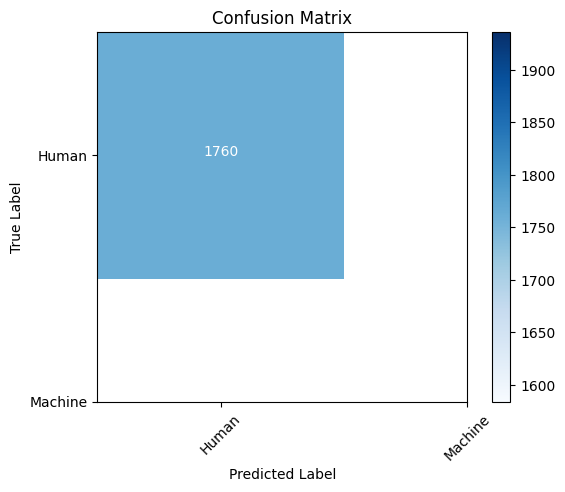

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = ['Human', 'Machine']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Get Score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,y_true,target_names=list(label2id.keys())))

# Reddit

In [ ]:
DPATH = r'../data/new_punc_data_reddit.csv'
batcher = SynBatcher(tnkzr_path=MPATH,has_targets = False)
eval_dm = SynDataModule(data_path=DPATH, task='hvm', label2id=label2id, batcher=batcher,srcs_to_keep=['reddit'])
preds = trainer.predict(model,eval_dm)
import numpy as np

indices = [i[0].reshape(len(i[0]), 1) for i in preds]
pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

indices = np.vstack(indices)
pred_labels = np.vstack(pred_labels)

pred_data = np.hstack((indices, pred_labels))
df_pred = pd.DataFrame(pred_data)

df = pd.read_csv(DPATH)
# filtered_df = df[df['src']=='aa_paper']
filtered_df = df[df['src']=='reddit']
temp=[]
c=0
for index,rows in filtered_df.iterrows():
  # if label2id[rows['alg']] in ['0','1','2','3','4','5','6','7','9','10']:
  if rows['alg'] == 'human':
    temp.append([c,0])
  else:
    temp.append([c,1])
  c+=1
  # print(rows['alg'])
temp_df = pd.DataFrame(temp,columns=['0','1'])
print(temp_df)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# example ground truth and predictions
y_true = temp_df['1'].to_list()
y_pred = df_pred[1].to_list()

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
classes = ['Human', 'Machine']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Get Score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,y_true,target_names=list(label2id.keys())))